In [1]:
# ruta clases personalizadas
import sys
ruta_clases = "C:/Users/jgpg000.edu/Desktop/SandBox/clases"
sys.path.append(ruta_clases)

## LIBRERIAS
from pprint import pprint
import pandas as pd
import fitz
from clase_datos import *
from clase_dataset import *
from tqdm import tqdm
import math
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

#### Cargar base de datos

In [2]:
## Cargamos los chunks de texto

# Cargamos excel de proveedores
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/"
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/base_datos/"
lista_material = pd.read_excel(
    f"{ruta_excel}proveedores_total.xlsx", dtype=str, header=0
    ).to_numpy()
if len(lista_material[lista_material == "nan"]) > 0:
    print("¡Revisa la lista de materiales!")
    raise Exception("Hay valores nulos en la lista de materiales")

# Cargamos documentos
documentos = []
for equipo, proveedor, modelo, pdfs, proyecto in tqdm(lista_material):
    ruta_cargar = f"C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/{proyecto}/"
    if (pdfs == None) or (type(pdfs) is not str): continue
    documento = Documento.cargar(ruta_guardar, ruta_cargar, pdfs)
    documentos.append(documento)
print(len(documentos))

# Convertimos en Langchain
documentos_langchain = []
# Create a document from rows in archivo_textos
for documento in tqdm(documentos):
    #print(documento.nombre_pdf)
    metadata = documento.show()
    #print(metadata)
    documento_langchain = Document(documento.texto_traducido,
                    metadata={
                        key: value for key, value in metadata.items() if key in ['nombre_pdf', 'modelo', 'proveedor', 'equipo']
                        }
                    )
    documentos_langchain.append(documento_langchain)
    if documento.resumenes is None:
        continue
    for resumen_tabla in documento.resumenes:
        resumen_tabla_langchain = Document(resumen_tabla,
                    metadata={
                        key: value for key, value in metadata.items() if key in ['nombre_pdf', 'modelo', 'proveedor', 'equipo']
                        }
                    )
        resumen_tabla_langchain.metadata["tabla"] = True
        documentos_langchain.append(resumen_tabla_langchain)
print(f"Se han cargado {len(documentos)} documentos.")

# Dividimos en chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=30,
    length_function=len,
    is_separator_regex=False,
)

# Dividimos cada texto en chunks
chunks_texto = text_splitter.split_documents(documentos_langchain)
print(f"Hay {len(chunks_texto)} chunks de texto.")

100%|██████████| 59/59 [00:00<00:00, 248.75it/s]


57


100%|██████████| 57/57 [00:00<00:00, 7966.52it/s]


Se han cargado 57 documentos.
Hay 5866 chunks de texto.


#### Modelo RAG

In [3]:
tamano = "large"
model = f"text-embedding-3-{tamano}"
ruta_guardar_vectores = "C:/Users/jgpg000.edu/Desktop/Dataset/proveedores/base_datos_vectores/"
template_sistema = """ Eres un asistente de una empresa encargada de smart cities.
Como preguntas, te van a adjuntar listas de requisitos de equipo para proyecto.
Tu labor es responder con el nombre de los equipos que encuentres que cumplan los requisitos, así como suministrar la información de estos dispositivos en relación a los requisitos.
Usa la información añadida en el contexto para responder a la pregunta pero no hagas referencias al mismo.
Se añade como metadato tanto el proveedor como el nombre a los que pertenece el contexto devuelto.
Responde únicamente con la especificación que se pide. Si no aparece di que no lo sabes.
Pregunta: {question}
Metadato: {metadata}
Contexto: {contexts}
La respuesta tiene que tener el siguiente formato:
- Nombre del equipo y proveedor.
- Especificaciones que se han preguntado y aparecen en el contexto.
Respuesta:
"""

modelo_llm = "gpt-4o"
vectorstore = crear_database(f"{ruta_guardar_vectores}{tamano}_esp", chunks_texto, nombre_embedding = "text-embedding-3-large")
print(f"El espacio tiene {vectorstore.index.ntotal} vectores.")
retriever = crear_retriever(vectorstore)
rag = crear_RAG(retriever=retriever,
                plantilla_RAG=template_sistema,
                model=modelo_llm)
#rag ## crear clase para mostrar las propiedades de cada rag

El espacio tiene 5866 vectores.


In [5]:
len(vectorstore.index_to_docstore_id) #Debería coincidir con el de arriba (numero de documentos)

5872

#### Generamos respuestas del dataset

In [5]:
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/QA_Dataset.xlsx"
qa = QADataset(ruta_excel)
qa.show()[:3]

,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,nan,nan,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,nan,nan,Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,nan,nan,Sonómetro B&K 2245 Sound Level Meter de HBK. \...


In [6]:
res = qa.generar_respuesta_individual(rag, 0)
res

{'contexts': [Document(page_content='La cámara LPR y la cámara de entorno pueden detectar matrículas de más de 70 países. Para la cámara LPR, hay tres opciones de sensores: Opción 1: 3.2MP 1/1.8” mono Global Shutter CMOS IMX265 con lentes de 11-50mm o 5.2-58.8mm (con zoom, foco y control del iris motorizados). Opción 2: 5MP 2/3’’ mono', metadata={'nombre_pdf': 'neurallabs-NL-GHOST-AI-ES-2024', 'modelo': 'NL Ghost AI', 'proveedor': 'Neural Labs', 'equipo': 'camara', 'tabla': True}), Document(page_content='Vehículos transitando en contrasentido. [LISTA] Vehículos estacionados en zonas prohibidas. [LISTA] Vehículos que no respectan la señal de STOP. [LISTA] Y más. Toda infracción detectada se registra junto a vídeos de la cámara de entorno que muestran evidencia de la infracción. La metadata es', metadata={'nombre_pdf': 'neurallabs-NL-GHOST-AI-ES-2024', 'modelo': 'NL Ghost AI', 'proveedor': 'Neural Labs', 'equipo': 'camara'}), Document(page_content='Seguridad EN IEC 62368-1 IEC 62368-1 UL

KeyError: 'proveedores'

In [7]:
qa.generar_respuestas(rag)
qa.show()[:4]

Se han generado las respuestas a las 16 preguntas.


,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,"- Nombre del equipo y proveedor: NL Ghost AI, ...",[La cámara LPR y la cámara de entorno pueden d...,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,- Nombre del equipo y proveedor: H5A PTZ Resis...,"[IK10, IP66, 2 50 m IR 1 45 250 m (820 pies) S...",Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,"- Nombre del equipo y proveedor: B&K 2245, HBK...",[[TABLA] El modelo de sonómetro B&K 2245 del p...,Sonómetro B&K 2245 Sound Level Meter de HBK. \...
3,Las especificaciones mínimas de los sensores s...,- Nombre del equipo y proveedor: Smart Parking...,[magnético”. Figura 7.1.1: Arquitectura de red...,Sensor Smart Parking Node de Libelium. Princip...


In [8]:
## GUARDAMOS EL DATASET CON LAS RESPUESTAS GENERADAS POR EL MODELO
## formato nombre: QA-modelo-Q#: QA-(modeloRAG)-(num. preg. dataset)
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-baseline_esp_large-Q16"

qa.guardar(ruta_guardar, nombre_archivo) # guarda en csv

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-baseline_esp_large-Q16.csv


In [4]:
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-baseline_esp_large-Q16"
## Comprobar que se ha guardado correctamente (cargando el modelo)
qa = QADataset(f"{ruta_guardar}{nombre_archivo}.csv")
qa.show()[:4]
qa.show_metrics()[:3]

,answer_relevancy,context_relevancy,context_recall,answer_similarity,answer_correctness,precision_bertscore,recall_bertscore,f1_bertscore,mismo_producto,especificaciones_correctas,especificaciones_correctas_norm
0,NaN,0.0,NaN,0.934656,0.621899,0.712287,0.683323,0.697505,1,4,0.25
1,NaN,0.0,NaN,0.893775,0.314353,0.642425,0.516912,0.572874,0,2,0.08
2,NaN,1.0,NaN,0.871876,0.703286,0.757178,0.757071,0.757124,1,9,0.50


In [10]:
qagen = qa.show()
qagen[:4]

,question,answer,contexts,ground_truth
0,Las especificaciones mínimas de las cámaras se...,"- Nombre del equipo y proveedor: NL Ghost AI, ...",[La cámara LPR y la cámara de entorno pueden d...,NL GHOST AI procesa analíticas de vídeo aplica...
1,Las especificaciones mínimas de las cámaras PT...,- Nombre del equipo y proveedor: H5A PTZ Resis...,"[IK10, IP66, 2 50 m IR 1 45 250 m (820 pies) S...",Cámara 2.0C-H4IRPTZ-DP30-WP del fabricante Avi...
2,Los sonómetros deberán satisfacer las siguient...,"- Nombre del equipo y proveedor: B&K 2245, HBK...",[[TABLA] El modelo de sonómetro B&K 2245 del p...,Sonómetro B&K 2245 Sound Level Meter de HBK. \...
3,Las especificaciones mínimas de los sensores s...,- Nombre del equipo y proveedor: Smart Parking...,[magnético”. Figura 7.1.1: Arquitectura de red...,Sensor Smart Parking Node de Libelium. Princip...


#### Evaluamos la calidad de las respuestas generadas

In [ ]:
##### LISTA METRICAS #####
# ['answer_relevancy', 'context_relevancy', 'context_recall', 'answer_similarity',
# 'answer_correctness', 'precision_bertscore', 'recall_bertscore', 'f1_bertscore',
# 'mismo_producto', 'especificaciones_correctas', 'especificaciones_correctas_norm']

In [3]:
from ragas.metrics import context_relevancy, answer_similarity, answer_correctness
metricas = [context_relevancy, answer_similarity, answer_correctness]

# generamos todas las métricas con el siguiente bucle
result_ragas = qa.ragas(metricas= metricas)
qa.bertscore()
qa.es_mismo_producto(modelo_llm="gpt-4o")
qa.son_especificaciones_correctas(modelo_llm="gpt-4o")

# Guardamos el dataset con métricas
ruta_guardar = "C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/"
nombre_archivo = "QA-baseline_esp_large-Q16"
qa.guardar(ruta_guardar, nombre_archivo)

NameError: name 'qa' is not defined

In [27]:
# Incluimos la métrica del número de especificaciones correctas normalizadas
ruta_excel = "C:/Users/jgpg000.edu/Desktop/Dataset/QA_Dataset.xlsx"
dataset = pd.read_excel(ruta_excel, sheet_name="QA2", dtype=str, header=0)
num_especificaciones = dataset['nº ENCONTRADAS EN DATASHEET'].dropna().astype(int).reset_index(drop=True)

qa.son_especificaciones_correctas_norm(num_especificaciones)
qa.guardar(ruta_guardar, nombre_archivo)
qa.especificaciones_correctas_norm[:3]

El archivo ya existe.
Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-baseline_esp_large-Q16.csv


0    0.25
1    0.08
2    0.50
Name: nº ENCONTRADAS EN DATASHEET, dtype: float64

#### Gráfico de métricas
Además del gráfico se ve bien en wandb

In [ ]:
qa.mismo_producto_individual()

In [6]:
qa.especificaciones_correctas

[4, 2, 9, 4, 4, 3, 9, 7, 13, 2, 6, 2, 11, 4, 13, 2]

La QA correcta 14 tiene tantas especificaciones_correctas sin acertar el producto porque la mayoría de la ground_truth es "no lo sé".

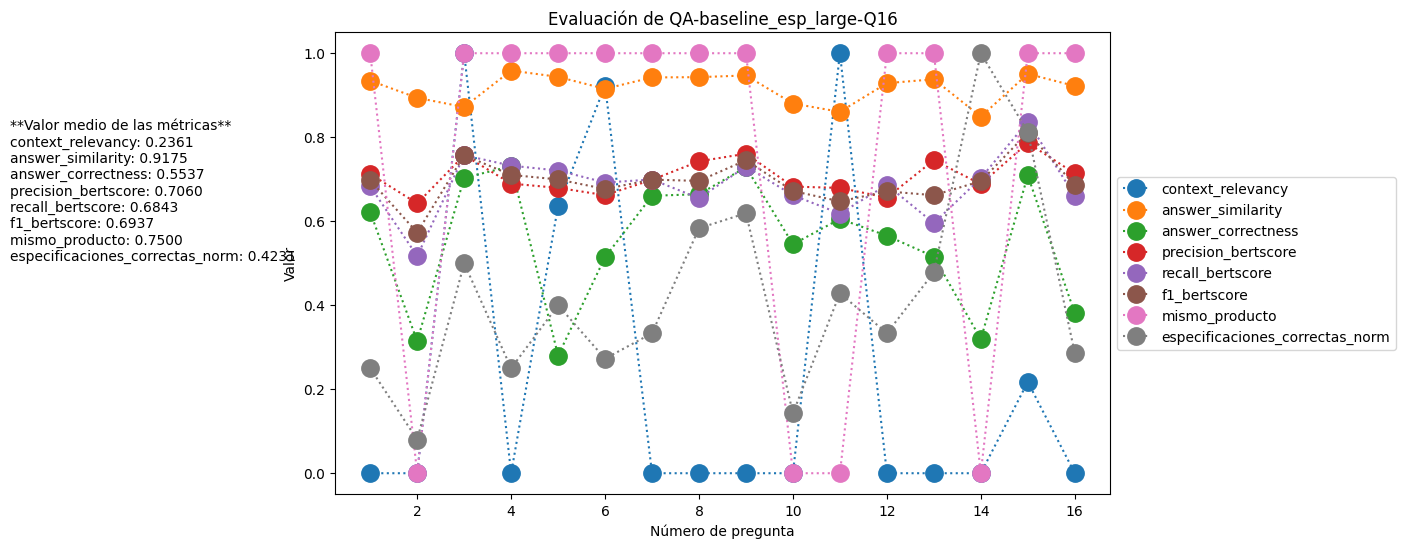

In [3]:
metricas = QADataset.columnas_metricas.copy()
metricas.remove("especificaciones_correctas")
metricas.remove("answer_relevancy")
metricas.remove("context_recall")

ruta_graficos = "C:/Users/jgpg000.edu/Desktop/Graficos/"
nombre_archivo = "QA-baseline_esp_large-Q16"
qa.grafico(nombre_archivo, ruta_graficos, metricas = metricas)

In [4]:
#fila excel
i = 16
#modificar metrica a mano
qa.mismo_producto[i-2] = 1

Se ha guardado el dataset en C:/Users/jgpg000.edu/Desktop/Dataset/qa_generados/QA-baseline_esp_large-Q16.csv


#### Tracing con wandb

In [16]:
import wandb
from wandb.sdk.data_types.trace_tree import Trace

# cargamos datos
status = "success"
status_message = (None,)
dataset_questions = qa.show()
dataset_metrics = qa.show_metrics()
i=0
nombre_archivo = "QA-baseline_esp_large-Q16"
dataset = pd.concat([dataset_questions, dataset_metrics], axis=1)
# start a wandb run to log to
wandb.init(project="trace-ragas", name=nombre_archivo)
for i in range(len(dataset)):
        fila = dataset.loc[i]
        # create a span in wandb
        root_span = Trace(
            name=f"Q{i}",
            kind="chain",  # kind can be "llm", "chain", "agent" or "tool"
            status_code=status,
            status_message=status_message,
            inputs = {
                    col: fila[col] for col in QADataset.columnas_dataset if col in fila  
                    },
            outputs = {
                    col: fila[col] for col in QADataset.columnas_metricas if col in fila
                    }
        )
        # log the span to wandb
        root_span.log(name="rag_trace")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jgpg000-edu (jgpginnovasur). Use `wandb login --relogin` to force relogin
